# Assignment 3 - Kaggle - Digit Recognizer

# Abstract

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

For this Assignemnt, I did a competition in Kaggle - Digit Recognizer, run, summarize and tweak the best public kernel of this competition in Kaggle. In this competition, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We are encouraged to experiment with different algorithms to learn first-hand what works well and how techniques compare.

# Analysis

## Part 1: My own work in Competition

See https://github.com/INFO6105-Spring19-02/assignment-3-kaggle-MandyMY/blob/master/Digit%20Recognizer%20-%20mandymy.ipynb

## Part 2: Best Kernel in Kaggle (After tweak&extend )

### Summary

The origin Link of this Kernel: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6, In this kernel, Yassine Ghouzam gave us a clear and detailed process to do the Digit Recognizer Competition. His solution has five steps.

Firstly, he loaded the libraries which are used in the process, he choosed to build model with keras API (Tensorflow backend). 

In the second part, he prapared the data, he loaded the train and test data provided by Kaggle, get that we have similar counts for the 10 digits and there is no missing values in the train and test dataset. Then he made the data be more suitable for CNN modeling and evaluation: performed a grayscale normalization to reduce the effect of illumination's differences, reshape all data to 28x28x1 3D matrices, encode numbers' lables to one hot vectors and choosed to split the train set in two parts - a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model. At that time, all the preparations for this task have been completed.

The Third part is the major part of this solution - Building model and training data. This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset, includes the convolutional (Conv2D) layer, the pooling (MaxPool2D) layer, the Flatten layer and two fully-connected (Dense) layers. Then he set up a score function, a loss function and an optimisation algorithm. In order to make the optimizer converge faster and closest to the global minimum of the loss function, he used an annealing method of the learning rate (LR). At last, fit the model with data augmentation to prevent overfitting.

The fourth step is doing some evaluations for the model, the author plotted the loss and accuracy curves for training and validation, got that this model is very well trained. And he plotted the confusion matrix of the validation results, got that CNN has some little troubles with the 4 digits, hey are misclassified as 9, then he printed six most important errors.

At the lasted step, predicted results and saved the result as cnn_mnist_datagen.csv

### 1. Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


### 2. Data preparation

#### 2.1 Load data

In [2]:
# Load the data
train = pd.read_csv("../Datasets/train.csv")
test = pd.read_csv("../Datasets/test.csv")

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

In [5]:
# Load more data from mnist
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

In [6]:
# Combine all data
X_train = np.concatenate((X_train, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

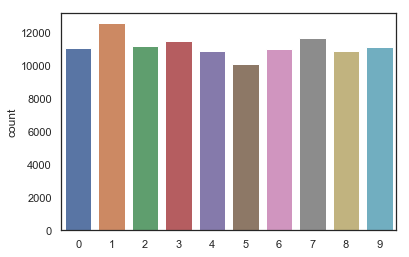

In [7]:
g = sns.countplot(Y_train)

We have similar counts for the 10 digits.

#### 2.2 Check for null and missing values

In [3]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

It checks for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

#### 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [9]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

#### 2.4 Reshape

In [10]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

#### 2.5 Label encoding

In [11]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

#### 2.6 Split training and valdiation set

In [12]:
# Set the random seed
random_seed = 2

In [13]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

It choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

We can get a better sense for one of these examples by visualising the image and looking at the label.

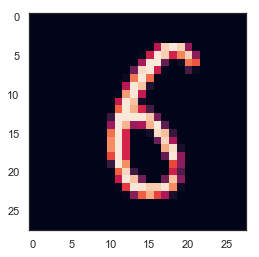

In [14]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

### 3. CNN

#### 3.1 Define the model

It used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset, includes the convolutional (Conv2D) layer, the pooling (MaxPool2D) layer, the Flatten layer and two fully-connected (Dense) layers. 

In [15]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 3.2 Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. And the most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

In [16]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [17]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, it used an annealing method of the learning rate (LR).

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 5 #Incress the epochs
batch_size = 86

#### 3.3 Data augmentation

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

In [20]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [21]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , shuffle=True, callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 331s - loss: 0.2311 - acc: 0.9269 - val_loss: 0.0339 - val_acc: 0.9888
Epoch 2/5
 - 322s - loss: 0.0783 - acc: 0.9768 - val_loss: 0.0305 - val_acc: 0.9908
Epoch 3/5
 - 540s - loss: 0.0652 - acc: 0.9807 - val_loss: 0.0281 - val_acc: 0.9910
Epoch 4/5
 - 534s - loss: 0.0639 - acc: 0.9827 - val_loss: 0.0303 - val_acc: 0.9910
Epoch 5/5
 - 416s - loss: 0.0647 - acc: 0.9823 - val_loss: 0.0310 - val_acc: 0.9918


In [22]:
# Save result model
model.save('../Models/kernel_model.h5')

### 4. Evaluate the model

#### 4.1 Training and validation curves

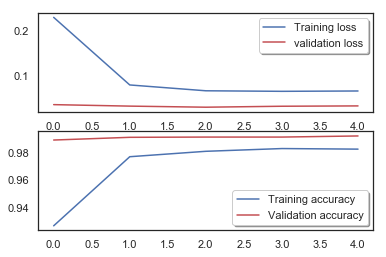

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The code below is for plotting loss and accuracy curves for training and validation. We can get that our model is very well trained.

#### 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.<br>
It plot the confusion matrix of the validation results.

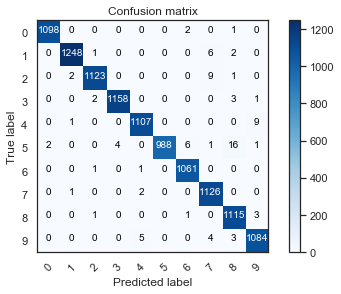

In [24]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set. However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.<br>
I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

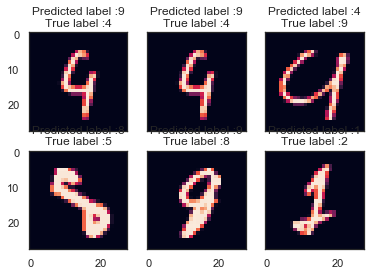

In [25]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous.<br>
For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

### 5. Prediction and submition

In [26]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [28]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("../Datasets/cnn_mnist_datagen.csv",index=False)

### Tweak & Extend

#### Loaded more data: 
    At In[5] to In[6], I loaded more date from mnist in keras.datasets, can then combined them with the origin data provided. Because more training data means higher accuracy. And on the other hand, handle origin data and make some changes, then combined the changed data with the origin data also can have the same effect.

#### Add attribution "shuffle" in fit:
    At In[21], I added shuffle attribution, it means whether to shuffle the training data before each epoch. It will improve the randomness of data and make the traing result more precise.

#### Save model after training:
    At In[22], I added model.save(/path), the result model after each times training will be saved to the path, it will be conveniently if you want to load a result model or if you want to continue your last training.

# Conclusion

Both the kernel I selected and my own solution use CNN to build the model. <br>
At the end, I achieved top 5% of the competition.

# Contributions Statement

Almost code (85%) in 'Part 1: My own work in Competition' is my own work.<br>

Almost code (85%) in 'Part 2: Best Kernel in Kaggle (After tweak&extend)' is cited from Part 2: Best Kernel in Kaggle (After tweak&extend )

# Citations

https://www.kaggle.com/c/digit-recognizer

https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6